In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [2]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class PenultimateOutputsDataset(Dataset):
    def __init__(self, folder_path, device='cpu'):
        with open(f'{folder_path}/penultimate_layer_outputs/data.json') as data:
            self.data_tensors = json.load(data)
        self.file_list = [f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{index}.pt' for index in range(self.data_tensors['last_file_indice']+1)]
        self.labels = torch.load(f'{folder_path}/penultimate_layer_labels.pt', map_location=device)
        self.length = self.data_tensors['min_size_segmentation']*self.data_tensors['last_file_indice']+torch.load(f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{self.data_tensors["last_file_indice"]}.pt', map_location=device).shape[0]
        self.device = device
        self.data_cache = None
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        if index < 0 or index >= self.length :
           raise ValueError(f'Index need to be between 0 and {self.length-1}')
        index_file = index//self.data_tensors['min_size_segmentation']
        index_in_file = index%self.data_tensors['min_size_segmentation']
        if (self.data_cache is None) or self.data_cache[0] != index_file :
            file = self.file_list[index_file]
            tensors = torch.load(file, map_location=self.device)
            self.data_cache = (index_file, tensors)
        tensor = self.data_cache[1][index_in_file]
        label = self.labels[index]
        return tensor, label


In [4]:
outputs_folder = "../data/saved_outputs"
batch_size = 256
nb_epoque = 60
nb_classe = 1000
input_size = 2048


weight_decay_parameter = 1e-4
learning_rate = 0.1
momentum = 0.9
lr_decay_step = 20
decay_rate = 0.1

moyenne_erreur_classe_model = []
list_epoch = []
loss_epoch = []
dataset = PenultimateOutputsDataset(outputs_folder)
train_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)

In [5]:
class LogisticRegression(nn.Module): 
    def __init__(self, input_size, num_classes): 
        super(LogisticRegression, self).__init__() 
        self.linear = nn.Linear(input_size, num_classes) 
  
    def forward(self, x): 
        out = self.linear(x) 
        return out 

In [6]:
for i in range(nb_epoque):
    
    model = LogisticRegression(input_size=input_size, num_classes=nb_classe)
    model.load_state_dict(torch.load(f'../data/saved_models/same_parameter_real_optimized_function/epoch-{i}.pt', map_location='cpu'))
    model = model.to(DEVICE)
    model.eval()
    
    list_epoch.append(i)
    
    erreur_total_classe = [0 for j in range(nb_classe)]
    nb_image_classe = [0 for k in range(nb_classe)]
    
    model = model.to(DEVICE)
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(train_loader, desc="View"): 
            i_image = 0
            
            # Move inputs and labels to the device 
            inputs = inputs.to(DEVICE) 
            labels = labels.to(DEVICE) 
      
            # Forward pass 
            outputs = model(inputs) 
            erreur = torch.nn.functional.cross_entropy(outputs,labels,reduction='none') + weight_decay_parameter * sum(t.pow(2).sum().item() for t in model.state_dict().values()) / 2
            vrai_loss = torch.mean(erreur).item() #recupère la loss du batch            
        
            
            for val in erreur:
                erreur_total_classe[labels[i_image].item()] += val.item()
                nb_image_classe[labels[i_image].item()] += 1    
                i_image+=1
                
        loss_epoch.append(vrai_loss)
        moyenne_erreur_classe_model.append((torch.tensor(erreur_total_classe)/torch.tensor(nb_image_classe)).tolist())
            

View: 100%|████████████████████████████████████████████████████████████████████████| 5005/5005 [01:56<00:00, 42.87it/s]


In [47]:
moyenne_erreur_classe_model = torch.tensor(moyenne_erreur_classe_model)
t_k = [torch.argmin(moyenne_erreur_classe_model[l]).item() for l in range(nb_classe)]
r_k = [torch.min(moyenne_erreur_classe_model[m]).item() for m in range(nb_classe)]
t = torch.argmin(loss_epoch)
r_t = torch.min(loss_epoch)
decalage = torch.abs(torch.tensor(t_k) - t.item())
regret = torch.abs(torch.tensor(r_k) - r_k[t])

C:\Users\vince\AppData\Local\Temp\ipykernel_5204\3974974189.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  moyenne_erreur_classe_model = torch.tensor(moyenne_erreur_classe_model)


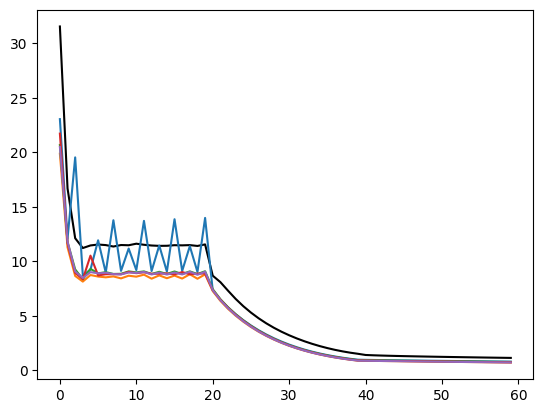

In [48]:
plt.plot(list_epoch,loss_epoch,color='black')
for n in range(10,15):
    plt.plot(list_epoch,moyenne_erreur_classe_model[n])